<a href="https://colab.research.google.com/github/deysi-caraballo/tfm/blob/main/TFM_entrenamiento_TL_preguntas_crudas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se procede ahora al entrenamiento del modelo de clasificación mono-etiqueta basándonos en Transformers y aprendizaje transferido (Transfer Learning)

# Análisis, preprocesamiento y preparación de los datos

In [1]:
!pip install pandas

In [2]:
!pip install python-snappy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.2 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn

In [4]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 33.7 MB/s eta 0:00:00


In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00


In [6]:
!pip install pysentimiento

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=9c66fb699d71755b6ea31aa1fd169e82b0ff577842421fd0221e87bbb27f137d
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


**NOTA:** antes de continuar debe reiniciarse el runtime

# Importación del dataset crudo en formato Parquet

En primer lugar, nos preparamos para descargar el fichero Parquet de datos crudos desde Google Cloud Storage hasta nuestro sistema de ficheros local de Google Colab

In [1]:
import os
import google.auth

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/sa.json'

In [2]:
!export GOOGLE_APPLICATION_CREDENTIALS=/content/sa.json

In [3]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/sa.json


In [4]:
!gcloud config set project '800463162730' #'snappy-guard-389922'

Updated property [core/project].


In [5]:
!gcloud auth login --cred-file=$GOOGLE_APPLICATION_CREDENTIALS


Authenticated with service account credentials for: [tfm-pasalera@snappy-guard-389922.iam.gserviceaccount.com].
Your current project is [800463162730].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [6]:
!gsutil cp gs://dataprep-staging-f1ae6292-d58f-4922-af3a-1cf0b5492123/mendoza.dc6@gmail.com/jobrun/preguntas-crudo-aumentado.parquet /content/preguntas-crudo.parquet

Copying gs://dataprep-staging-f1ae6292-d58f-4922-af3a-1cf0b5492123/mendoza.dc6@gmail.com/jobrun/preguntas-crudo-aumentado.parquet...
\ [1 files][ 14.4 MiB/ 14.4 MiB]                                                
Operation completed over 1 objects/14.4 MiB.                                     


In [7]:
import pandas as pd

preguntas_df = pd.read_parquet('/content/preguntas-crudo.parquet', engine='pyarrow')

In [8]:
preguntas_df = preguntas_df[['texto', 'id_ministerio', 'split']]
preguntas_df

,texto,id_ministerio,split
0,Grupo Parlamentario Socialista de Cortes Gener...,5,train
1,C.DIP 80898 20/03/2018 19:46 CS Congreso de lo...,10,train
2,C.DIP 79938 14/03/2018 17:32 A LA MESA DEL CON...,5,train
3,BRE 6 SENADO AUTOR: SENADO XII LEGISLATURA REG...,11,train
4,BRE 6 SENADO AUTOR: SENADO XII LEGISLATURA REG...,11,train
...,...,...,...
7608,Grupo Parlamentario Socialista de Cortes Gener...,13,test
2915,C. DIP 84160 11/04/2018 18:22 GRUPO PARLAMENTA...,5,test
7874,BRE 6 SENADO AUTOR: SENADO XII LEGISLATURA REG...,14,test
3582,Grupo Parlamentario Socialista de Cortes Gener...,5,test


Definimos la lista de ministerios para que sea mostrada posteriormente en los reportes de evaluación

In [9]:
lista_ministerios = ['M. de Defensa',\
                     'M. de Justicia',\
                     'M. del Interior',\
                     'M. de Fomento',\
                     'M. de Asuntos Exteriores y de Cooperación',\
                     'M. de Hacienda y Función Pública',\
                     'M. de Empleo y Seguridad Social',\
                     'M. de Economía, Industria y Competitividad',\
                     'M. de Energía, Turismo y Agenda Digital',\
                     'M. de Agricultura y Pesca, Alimentación y Medio Ambiente',\
                     'M. de la Presidencia y para las Administraciones Territoriales',\
                     'M. de Sanidad, Servicios Sociales e Igualdad',\
                     'M. de Educación, Cultura y Deporte']

In [10]:
preguntas_df = preguntas_df.reset_index()

# Análisis del dataset crudo

Antes de continuar, vamos a verificar que los documentos están correctamente balanceados para todos los posibles ministerios. Para ello, vamos a representar gráficamente cuántos documentos hay en nuestro conjunto de entrenamiento por cada posible ministerio.

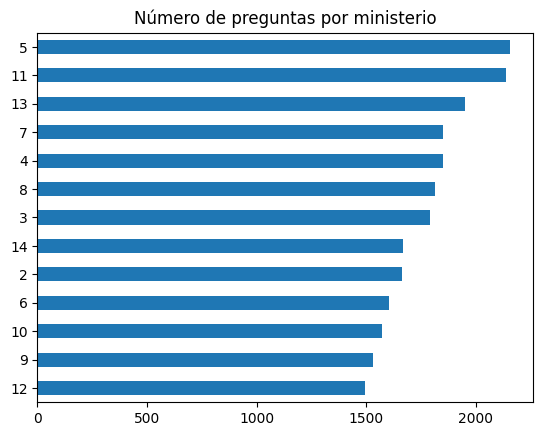

In [11]:
import matplotlib.pyplot as plt

preguntas_df["id_ministerio"].value_counts(ascending=True).plot.barh()
plt.title("Número de preguntas por ministerio")
plt.rcParams['figure.figsize'] = [20, 50]
plt.show()

En nuestro dataset original solo hay dos splits: train y test. Sin embargo, para trabajar con estos algoritmos, es mejor tener un tercer split de validación. Por tanto, vamos a mezclarlos y a volver a generar, ahora sí, tres splits:
* Split de entrenamiento: 70% de los datos
* Split de evaluación: 20% de los datos
* Split de validación: 10% de los datos

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

# Primero separamos el 70% que corresponde al dataset de entrenamiento
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=8)
X = preguntas_df['texto']
y = preguntas_df['id_ministerio']

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

preguntas_df_train = pd.DataFrame(data={'texto': X_train, 'id_ministerio': y_train, 'split': 'train'})
preguntas_df_test = pd.DataFrame(data={'texto': X_test, 'id_ministerio': y_test, 'split': 'test'})

# Ahora repetimos la operación a partir del 30% restante almacenado en preguntas_df_test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=8)
X = preguntas_df_test['texto']
y = preguntas_df_test['id_ministerio']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

for test_index, val_index in sss.split(X, y):
    X_test, X_val = X[test_index], X[val_index]
    y_test, y_val = y[test_index], y[val_index]

preguntas_df_test = pd.DataFrame(data={'texto': X_test, 'id_ministerio': y_test, 'split': 'test'})
preguntas_df_val = pd.DataFrame(data={'texto': X_val, 'id_ministerio': y_val, 'split': 'val'})

preguntas_df = pd.concat([preguntas_df_train, preguntas_df_test, preguntas_df_val])

In [13]:
X_train = preguntas_df_train['texto']
X_valid = preguntas_df_val['texto']
X_test = preguntas_df_test['texto']

y_train = preguntas_df_train['id_ministerio'].apply(lambda x: str(x))
y_valid = preguntas_df_val['id_ministerio'].apply(lambda x: str(x))
y_test = preguntas_df_test['id_ministerio'].apply(lambda x: str(x))

X_train

7050     grupo parlamentario socialista de cortes gener...
19050    c. dip 86672 25 / 04 / 2018 13 : 06 cs congres...
20491    bre 6 senado autores : senado iv legislatura r...
7047     grupo parlamentario socialista de cortes gener...
12516    c. s 79923 14 / 03 / 2018 17 : 20 partit democ...
                               ...                        
3702     Grupo Parlamentario Socialista de Cortes Gener...
2531     Grupo Parlamentario Socialista de Cortes Gener...
14609    grupo parlamentario socialista de cortes gener...
18164    bre 6 senado autor : espana xii legislatura re...
2487     Grupo Parlamentario Socialista de Cortes Gener...
Name: texto, Length: 16161, dtype: object

Vamos a realizar lo que se conoce como one-hot encoding, una técnica de preprocesamiento de datos que se utiliza a menudo en la creación de modelos de aprendizaje automático. Se utiliza para convertir variables categóricas, es decir, variables que solo pueden tomar un número limitado de valores discretos, como cadenas de texto, en formato numérico.

En este caso, se utiliza la clase LabelBinarizer de scikit-learn para realizar one-hot encoding en las etiquetas de entrenamiento, validación y prueba. Luego, se utilizan los métodos fit_transform y transform para ajustar el encoder a los datos de entrenamiento y luego transformar los datos de validación y prueba, respectivamente.

El método fit_transform ajusta el encoder a los datos de entrenamiento y luego realiza la transformación. El método transform, por otro lado, solo realiza la transformación utilizando el encoder ya ajustado.

Una vez que se han realizado los one-hot encoding, cada etiqueta se representa como un vector de ceros y unos, donde solo una posición del vector tiene un valor de uno y el resto tiene un valor de cero. Por ejemplo, si tenemos tres categorías, A, B y C, entonces la etiqueta A se representaría como [1, 0, 0], la etiqueta B como [0, 1, 0] y la etiqueta C como [0, 0, 1].

Una vez que se han realizado los one-hot encoding, se puede utilizar el conjunto de datos transformado para entrenar un modelo de redes neuronales con Keras.


In [14]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Vamos a convertir los dataframes en datasets de HuggingFace, librería que vamos a utilizar para hacer aprendizaje transferido con un transformador. Intalaremos HuggingFace y la librería Dataset.

In [15]:
df_train = preguntas_df[preguntas_df['split'] == 'train'][['texto', 'id_ministerio']]
df_valid = preguntas_df[preguntas_df['split'] == 'val'][['texto', 'id_ministerio']]
df_test = preguntas_df[preguntas_df['split'] == 'test'][['texto', 'id_ministerio']]

In [16]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
     "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    }
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['texto', 'id_ministerio'],
        num_rows: 16161
    })
    valid: Dataset({
        features: ['texto', 'id_ministerio'],
        num_rows: 2286
    })
    test: Dataset({
        features: ['texto', 'id_ministerio'],
        num_rows: 4641
    })
})

In [17]:
dataset['train'][0]

{'texto': 'grupo parlamentario socialista de cortes generales c. dip 82745 05 / 04 / 2018 13 : 41 grupo socialista carrera de san jeronimo, 40 metro madrid dª mª aurora florez rodriguez, diputada por leon, perteneciente al grupo parlamentario socialista del congreso, al amparo desde lo establecido en el articulo 185 y 86 del vigente reglamento del congreso de los diputados, presenta la siguiente pregunta de que le sea contestada por escrito. ● la carretera nacional n - 630 en su recorrido para la provincia de leon muestra un evidente deterioro en el tramo comprendido entre leon y benavente. ● los habitantes de las localidades por por que transcurre esta via denuncian desde hace tiempo el lamentable estado de la carretera que provoca averias en los vehiculos, pinchazos y lunas rotas a consecuencia del desprendimiento de la capa superior del asfalto. c grupo a la mesa del congreso de los diputados parlamentario www. socialistasdelcongreso. es ora ¿ cual ha estado la inversion del ministe

Este código calcula los pesos de clase para equilibrar el conjunto de entrenamiento dada la desigual distribución de clases.

La función compute_class_weight de scikit-learn se utiliza para calcular los pesos de clase. Toma como argumentos el tipo de distribución deseado ('balanced' en este caso, que significa que se calculan pesos para que la media de las frecuencias de clase sea igual), las clases únicas del conjunto de entrenamiento y el vector de clases del conjunto de entrenamiento. Esto devuelve una lista de pesos, un peso para cada clase.

Luego, se convierte la lista a un tensor de PyTorch y se cambia su tipo de datos a float32 para poder utilizarlos en el proceso de entreno.

In [18]:
from sklearn.utils import class_weight
import numpy as np
import torch

weights = class_weight.compute_class_weight('balanced', classes=np.unique(dataset['train']['id_ministerio']), y=dataset['train']['id_ministerio'])
weights = torch.tensor(weights)
weights = weights.to(torch.float32)
weights

tensor([1.0671, 0.9921, 0.9600, 0.8238, 1.1060, 0.9592, 0.9789, 1.1597, 1.1301,
        0.8299, 1.1885, 0.9107, 1.0643])

Vamos a preparar las etiquetas de las categorías de ministerios para poder usar el transformador.

La línea dataset = dataset.class_encode_column("id_ministerio") convierte los valores de la columna "id_ministerio" del dataset en valores enteros. Esto es necesario para que la función de pérdida "CrossEntropyLoss" de PyTorch pueda procesar los datos.

La línea labels = dataset['train'].features['id_ministerio'] obtiene un objeto "ClassLabel" que contiene la información de las etiquetas de clase del conjunto de entrenamiento.

La línea dataset = dataset.rename_column("id_ministerio", "label") renombra la columna "id_ministerio" del dataset a "label". Esto es necesario para que el conjunto de datos tenga una columna con el nombre esperado por el modelo de clasificación de secuencias de Hugging Face.

La línea print(labels.names) imprime los nombres de las etiquetas de clase del conjunto de entrenamiento.

In [19]:
from datasets import ClassLabel

dataset = dataset.class_encode_column("id_ministerio")
labels = dataset['train'].features['id_ministerio']
dataset = dataset.rename_column("id_ministerio", "label")
print(labels.names)

Stringifying the column:   0%|          | 0/16161 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/16161 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/2286 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2286 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/4641 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4641 [00:00<?, ? examples/s]

['10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


# Aprendizaje transferido con Transformadores

Vamos a utilizar la librería Transformers de Hugging Face para entrenar un modelo de clasificación de secuencias utilizando un modelo de transformador preentrenado. Este código es para cargar el modelo pre-entrenado de clasificación de secuencias, específicamente un modelo de transformadores, para luego utilizarlo para clasificar tweets en diferentes categorías. Las líneas específicas son las siguientes:

   1. Importa las clases AutoTokenizer y AutoModelForSequenceClassification del módulo transformers.    
   2. Establece una variable transformer_model con una cadena de caracteres que contiene el nombre de un modelo de transformadores específico.
   3. Crea una variable device que contiene el dispositivo "cuda" si está disponible, o "cpu" en caso contrario.
   4. Crea una variable model que contiene un modelo de clasificación de secuencias de transformadores cargado desde el modelo especificado en la variable transformer_model, con el número de etiquetas especificado por la longitud del objeto labels.names. El modelo se ajusta para el dispositivo especificado en la variable device.
   5. Establece el modo de entrenamiento del modelo cargado.
   6. Crea una lista de tokens especiales para utilizar en el proceso de tokenización.
   7. Crea un tokenizador utilizando la clase AutoTokenizer y cargándolo a partir del modelo especificado en la variable transformer_model. El tokenizador no debe dividir los tokens especiales especificados y debe tener una longitud máxima de 128.
   8. Obtiene el vocabulario del tokenizador.
   9. Crea una lista de tokens nuevos que deben agregarse al vocabulario del tokenizador si no están ya incluidos en él.
   10. Imprime la lista de tokens nuevos.
   11. Si la lista de tokens nuevos no está vacía, agrega los tokens al vocabulario del tokenizador.
   12. Ajusta el tamaño de los vectores de tokens del modelo para que coincida con la longitud del vocabulario del tokenizador.
   13. Establece la longitud máxima del modelo en 128.
   14. Define una función tokenize que toma un lote de preguntas y los tokeniza utilizando el tokenizador.
   15. Crea un conjunto de datos codificado ds_enc a partir del conjunto de datos original, aplicando la función tokenize a cada elemento del conjunto de datos y agrupando los resultados en lotes de tamaño 32.

P.D. Muchos de estos pasos son necesarios debido a la arquitectura de robertuito. Para ello, hemos seguido las indicaciones de código en https://github.com/pysentimiento/robertuito Sin ellos, el proceso de entrenamiento daría lugar a multitud de errores.

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'pysentimiento/robertuito-base-cased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, num_labels = len(labels.names), return_dict=True)).to(device)
model.train()
special_tokens = ["USER", "url", "hashtag", "emoji"]
tokenizer=AutoTokenizer.from_pretrained(transformer_model, never_split=special_tokens, max_length=128)
vocab = tokenizer.get_vocab()
new_tokens_to_add = [tok for tok in special_tokens if tok not in vocab]
print(new_tokens_to_add)
if new_tokens_to_add:
    tokenizer.add_tokens(new_tokens_to_add)
model.resize_token_embeddings(len(tokenizer))
tokenizer.model_max_length = 128

def tokenize(batch):
    return tokenizer(batch["texto"], padding=False, truncation=True)

ds_enc = dataset.map(tokenize, batched=True, batch_size=32)
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")
ds_enc

Some weights of the model checkpoint at pysentimiento/robertuito-base-cased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-cased and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.w

['USER', 'url', 'hashtag', 'emoji']


Map:   0%|          | 0/16161 [00:00<?, ? examples/s]

Map:   0%|          | 0/2286 [00:00<?, ? examples/s]

Map:   0%|          | 0/4641 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['texto', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16161
    })
    valid: Dataset({
        features: ['texto', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2286
    })
    test: Dataset({
        features: ['texto', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4641
    })
})

In [21]:
ds_enc['train'][0]

{'texto': 'grupo parlamentario socialista de cortes generales c. dip 82745 05 / 04 / 2018 13 : 41 grupo socialista carrera de san jeronimo, 40 metro madrid dª mª aurora florez rodriguez, diputada por leon, perteneciente al grupo parlamentario socialista del congreso, al amparo desde lo establecido en el articulo 185 y 86 del vigente reglamento del congreso de los diputados, presenta la siguiente pregunta de que le sea contestada por escrito. ● la carretera nacional n - 630 en su recorrido para la provincia de leon muestra un evidente deterioro en el tramo comprendido entre leon y benavente. ● los habitantes de las localidades por por que transcurre esta via denuncian desde hace tiempo el lamentable estado de la carretera que provoca averias en los vehiculos, pinchazos y lunas rotas a consecuencia del desprendimiento de la capa superior del asfalto. c grupo a la mesa del congreso de los diputados parlamentario www. socialistasdelcongreso. es ora ¿ cual ha estado la inversion del ministe

Las características input_ids, token_type_ids y attention_mask son utilizadas para procesar los datos de entrada.


    'input_ids': una lista de números enteros que representan los índices de tokens del tweet en el vocabulario del tokenizador.
    'token_type_ids': una lista de números enteros que indican a qué segmento de texto pertenece cada token en el tweet.
    'attention_mask': una lista de números binarios que indican qué tokens del tweet deben tener en cuenta al realizar el procesamiento. En este caso, todos los tokens se tienen en cuenta.

Los índices de tokens se utilizan para codificar el tweet en una forma que puede ser procesada por el modelo de clasificación de secuencias. Los token_type_ids y la attention_mask se utilizan para indicar al modelo cómo debe procesar el texto del tweet. Por ejemplo, si el tweet contiene dos segmentos de texto distintos, como una pregunta y una respuesta, se podría utilizar un token_type_id diferente para cada segmento para indicar al modelo que deben procesarse de manera independiente. Por ejemplo, se podría utilizar un token_type_id de 0 para los tokens de la pregunta y un token_type_id de 1 para los tokens de la respuesta.

En estas líneas de código, se está realizando un procesamiento adicional del conjunto de datos para prepararlo para el finetuning. En particular, se establece el formato del conjunto de datos codificado en "torch" y se especifican las columnas "input_ids", "attention_mask", "token_type_ids" y "label" como columnas a incluir.


Definimos las métricas de evaluación mediante una función compute_metrics que se utiliza para calcular varias métricas de rendimiento para un modelo de clasificación. Esta función toma un objeto pred como entrada y devuelve un diccionario con las métricas de rendimiento calculadas.

Aquí hay una explicación detallada de cada línea de código:

    Se importa la función precision_recall_fscore_support de la librería scikit-learn.
    Se define la función compute_metrics.
    Las etiquetas verdaderas se obtienen del campo "label_ids" del objeto pred.
    Las predicciones del modelo se obtienen del campo "predictions" del objeto pred y se convierten en el índice de la clase con la mayor probabilidad utilizando el método argmax.
    Se calculan la precisión, el recall y el puntaje F1 macro utilizando la función precision_recall_fscore_support de scikit-learn.
    Se devuelve un diccionario con las métricas de rendimiento calculadas.

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Este código define una clase personalizada de entrenador para realizar el finetuning de un modelo de transformadores. La clase hereda de la clase Trainer y sobrescribe el método compute_loss para calcular la pérdida de entrenamiento de manera personalizada.

El método compute_loss toma como argumentos el modelo, los inputs y una bandera return_outputs. Los inputs incluyen las etiquetas de clasificación del conjunto de datos de entrenamiento y cualquier otra información necesaria para realizar el procesamiento del modelo. La bandera return_outputs indica si se deben devolver los resultados del procesamiento además de la pérdida.

En el código, la variable labels se inicializa con las etiquetas de clasificación de los inputs y se pasa como argumento al modelo junto con los demás inputs para obtener los resultados del procesamiento. Los resultados del procesamiento se almacenan en la variable outputs y se obtiene la variable logits, que contiene las predicciones del modelo para cada clase.

Luego se crea una función de pérdida loss_fct utilizando la clase torch.nn.CrossEntropyLoss y se le pasa como argumento el tensor de pesos opcional. La función de pérdida se ajusta al dispositivo especificado en la variable device.

Finalmente, se calcula la pérdida utilizando la función de pérdida y se devuelve junto con los resultados del procesamiento si se ha especificado la bandera return_outputs, o solo la pérdida en caso contrario. La pérdida se calcula aplicando la función de pérdida a la variable logits, que se ha redimensionado para tener la forma (-1, self.model.config.num_labels), y a la variable labels, que se ha redimensionado para tener la forma (-1). Esto permite aplicar la función de pérdida a cada una de las predicciones del modelo y cada una de las etiquetas de clasificación del conjunto de datos.

In [23]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights).to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Este código es utilizado para entrenar un modelo de transformadores utilizando la clase personalizada de entrenador CustomTrainer definida anteriormente.

En primer lugar, se establecen algunos parámetros de entrenamiento, como el tamaño del lote, el nombre del modelo finetuned, el número de épocas de entrenamiento, la tasa de aprendizaje, la relación de calentamiento, la tasa de decaimiento del peso, la estrategia de evaluación, la estrategia de guardado, la métrica para el mejor modelo y la opción de cargar el mejor modelo al final del entrenamiento. Estos parámetros se almacenan en la variable training_args utilizando la clase TrainingArguments de transformers. He aquí una explicación de cada parámetro:

1. output_dir: especifica la ruta del directorio donde se guardarán los resultados del entrenamiento, como los pesos del modelo y las métricas de evaluación.

2. num_train_epochs: especifica el número de épocas de entrenamiento. Una época es una iteración completa a través del conjunto de datos de entrenamiento. Aumentar el número de épocas de entrenamiento puede mejorar el rendimiento del modelo, pero también aumentará el tiempo de entrenamiento.

3. learning_rate: especifica la tasa de aprendizaje utilizada por el optimizador durante el entrenamiento. Por defecto, su valor es 5e-5 para el optimizador AdamW que viene por defecto. La tasa de aprendizaje controla el tamaño de los pasos que el optimizador toma al actualizar los pesos del modelo. Una tasa de aprendizaje más alta puede hacer que el modelo aprenda más rápido, pero también puede hacer que el modelo se sobreajuste (i.e. overfitting). Una tasa de aprendizaje más baja puede mejorar el rendimiento del modelo, pero también aumentará el tiempo de entrenamiento.

4. per_device_train_batch_size: especifica el tamaño del lote utilizado durante el entrenamiento. El tamaño del lote controla el número de ejemplos del conjunto de datos que se procesan en cada iteración del entrenamiento. Un tamaño de lote más grande puede mejorar el rendimiento del modelo, pero también puede aumentar el tiempo de entrenamiento y requerir más memoria.

5. per_device_eval_batch_size: especifica el tamaño del lote utilizado durante la evaluación. El tamaño del lote controla el número de ejemplos del conjunto de datos que se procesan en cada iteración de la evaluación. Un tamaño de lote más grande puede mejorar la precisión de la evaluación, pero también puede aumentar el tiempo de evaluación y requerir más memoria.

6. warmup_ratio: especifica la relación de calentamiento utilizada durante el entrenamiento. La relación de calentamiento controla cómo se aumenta la tasa de aprendizaje durante las primeras épocas de entrenamiento. Una relación de calentamiento más alta puede mejorar el rendimiento del modelo al permitir que la tasa de aprendizaje aumente más rápidamente, pero también puede aumentar el riesgo de sobreajuste.

7. weight_decay: especifica la tasa de decaimiento del peso utilizada durante el entrenamiento. La tasa de decaimiento del peso controla la regularización de los pesos del modelo y puede ayudar a evitar el sobreajuste. Una tasa de decaimiento del peso más alta puede mejorar el rendimiento del modelo al regularizar más los pesos, pero también puede reducir la precisión del modelo.

8. evaluation_strategy: especifica la estrategia de evaluación utilizada durante el entrenamiento. La estrategia de evaluación controla cuándo se evalúa el modelo durante el entrenamiento. Una estrategia de evaluación "época" significa que el modelo se evalúa al final de cada época de entrenamiento. Otras opciones incluyen "batches" para evaluar el modelo después de cada lote de entrenamiento o "global_step" para evaluar el modelo después de cada paso de entrenamiento.

9. save_strategy: especifica la estrategia de guardado utilizada durante el entrenamiento. La estrategia de guardado controla cuándo se guarda el modelo durante el entrenamiento. Una estrategia de guardado "época" significa que el modelo se guarda al final de cada época de entrenamiento. Otras opciones incluyen "batches" para guardar el modelo después de cada lote de entrenamiento o "global_step" para guardar el modelo después de cada paso de entrenamiento.

10. metric_for_best_model: especifica la métrica utilizada para determinar el mejor modelo durante el entrenamiento. La métrica del mejor modelo se utiliza para determinar cuándo se debe guardar una copia del modelo durante el entrenamiento. Por ejemplo, si se especifica "f1", se guardará una copia del modelo cada vez que la métrica F1 del modelo en el conjunto de datos de validación aumente.

11. load_best_model_at_end: especifica si se debe cargar el mejor modelo al final del entrenamiento. Si esta opción se establece en True, se cargará el mejor modelo guardado durante el entrenamiento al final del entrenamiento.

12. save_total_limit: especifica el número máximo de copias del modelo que se deben guardar durante el entrenamiento. Por ejemplo, si se establece en 1, solo se guardará la última copia del modelo guardado durante el entrenamiento.

13. report_to: especifica cómo se deben informar los resultados del entrenamiento. Las opciones incluyen "none" para no informar los resultados, "log" para informar los resultados en la salida de log, o "stdout" para imprimir los resultados en la consola.

Luego se crea una instancia de la clase Trainer pasándole como argumentos el modelo, los parámetros de entrenamiento, la función de cálculo de métricas, el conjunto de datos de entrenamiento, el conjunto de datos de validación, el tokenizador y el DataCollator.

Por último, se llama al método train de la instancia del entrenador para iniciar el proceso de entrenamiento. Durante el entrenamiento, se calculará la pérdida de entrenamiento utilizando el método compute_loss de la clase CustomTrainer y se utilizará para actualizar los pesos del modelo. Además, se calcularán las métricas de evaluación en el conjunto de datos de validación y se guardará el mejor modelo en función de la métrica especificada.

Para más info acerca de los parámetros que se pueden utilizar, consulta: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

In [26]:
from transformers import TrainingArguments

batch_size = 16
model_name = "finetuned_model_clasificacion_preguntas_tfm_es"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=100,
        learning_rate = 5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

trainer = CustomTrainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.272500,1.113421,0.686847,0.675506,0.676620
2,0.950700,0.848099,0.763347,0.752187,0.754387
3,0.698700,0.689249,0.801084,0.795881,0.795706
4,0.563800,0.615327,0.824367,0.819124,0.817282
5,0.447300,0.598956,0.839661,0.834675,0.832864
6,0.380000,0.554096,0.852534,0.846187,0.845533
7,0.333300,0.589871,0.846711,0.848055,0.846677
8,0.304900,0.638941,0.862210,0.857941,0.857102
9,0.281200,0.553777,0.868574,0.869339,0.867458
10,0.279800,0.577279,0.871575,0.871345,0.869777


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.272500,1.113421,0.686847,0.675506,0.676620
2,0.950700,0.848099,0.763347,0.752187,0.754387
3,0.698700,0.689249,0.801084,0.795881,0.795706
4,0.563800,0.615327,0.824367,0.819124,0.817282
5,0.447300,0.598956,0.839661,0.834675,0.832864
6,0.380000,0.554096,0.852534,0.846187,0.845533
7,0.333300,0.589871,0.846711,0.848055,0.846677
8,0.304900,0.638941,0.862210,0.857941,0.857102
9,0.281200,0.553777,0.868574,0.869339,0.867458
10,0.279800,0.577279,0.871575,0.871345,0.869777


TrainOutput(global_step=101100, training_loss=1.130777615427853, metrics={'train_runtime': 10985.0731, 'train_samples_per_second': 147.118, 'train_steps_per_second': 9.203, 'total_flos': 1.063139431548672e+17, 'train_loss': 1.130777615427853, 'epoch': 100.0})

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [27]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

{'test_loss': 1.0591545104980469, 'test_precision': 0.9003659346363718, 'test_recall': 0.9013164131662817, 'test_f1': 0.899912991018723, 'test_runtime': 9.2961, 'test_samples_per_second': 499.244, 'test_steps_per_second': 31.304}


Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [28]:
from sklearn.metrics import classification_report

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

          10       0.96      0.94      0.95       316
          11       0.94      0.87      0.90       430
          12       0.98      0.98      0.98       300
          13       0.86      0.87      0.87       392
          14       0.85      0.92      0.89       336
           2       0.95      0.94      0.95       335
           3       0.91      0.87      0.89       360
           4       0.77      0.89      0.82       372
           5       0.86      0.75      0.80       433
           6       0.93      0.94      0.93       322
           7       0.90      0.89      0.90       373
           8       0.85      0.90      0.87       364
           9       0.93      0.96      0.94       308

    accuracy                           0.90      4641
   macro avg       0.90      0.90      0.90      4641
weighted avg       0.90      0.90      0.90      4641



FIN